# Match-up basics - Points and PACE
**Author:** Ryan Vandermeulen and Eli Holmes (NOAA)</br>
Last updated: January 9, 2026

[![Colab Badge](https://img.shields.io/badge/Open_in_Colab-blue?style=for-the-badge)][colab-link]
[![Download Badge](https://img.shields.io/badge/Download-grey?style=for-the-badge)][download-link] [![JupyterHub](https://img.shields.io/badge/Jupyter_Hub-orange?style=for-the-badge)][jupyter-link]

<!--
<a href="javascript:void(0);" onclick="openJupyterWidget('https://github.com/fish-pace/2025-tutorials/blob/main/matchups.ipynb');">
    <img src="https://img.shields.io/badge/Open_in_JupyterHub-orange?style=for-the-badge" alt="JupyterHub Badge">
</a> 
-->

[download-link]: https://github.com/fish-pace/2025-tutorials/blob/main/matchups.ipynb
[colab-link]: https://colab.research.google.com/github/fish-pace/2025-tutorials/blob/main/matchups.ipynb
[jupyter-link]: https://nmfs-openscapes.2i2c.cloud/hub/user-redirect/lab?fromURL=https://raw.githubusercontent.com/fish-pace/2025-tutorials/main/matchups.ipynb

Fisheries research is rich in point-based observations: survey tows, catch locations, plankton samples, animal tag detections, CTD casts, acoustics, underwater imagery, what have you... These observations carry valuable biological information, and we often want to relate them to broader environmental conditions. The challenge is matching datasets efficiently across space and time. It's relatively straightforward to extract a point from a single satellite image, but going through multiple points and time stamps can be a major time-suck. So, let's take it one step at a time and set up a workflow to help us along. We're going to get some help from our friends at the [Southeast Area Monitoring & Assessment Program](https://seamapdata.gsmfc.org/), or SEAMAP. There is a lot of really cool fisheries data pertaining to the U.S. Gulf Coast in here (species, size, abundance, environmental parameters, and more) for us to experiment with.

> Learning Objectives:  

> 2. Import data from a NOAA Fisheries survey and show the locations on a satellite image
> 3. Extract PACE reflectance data across multiple corresponding dates/locations
> 3. Perform a rudimentary prediction model of fish abundance from the data

## *Are you ready?*

## Let’s dive in! 🐠


## Basic match-up

Let's start with a simple exercise. We're going to extract PACE Rrs data from a single defined location on a single date.

In [16]:
# data point
time = "2024-10-24"
lat = 26.79666
lon = -82.578

Let's just get a quick look at where we've targeted.

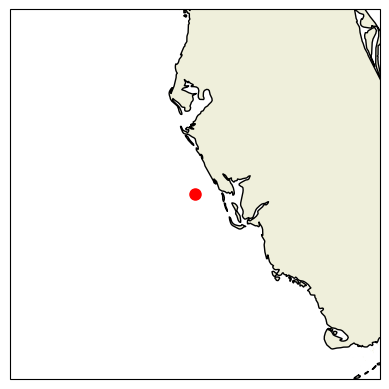

In [17]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

fig, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()})
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.plot(lon, lat, "ro", markersize=8)
ax.set_extent([lon-2, lon+2, lat-2, lat+2])
plt.show()

Oooooh, Chandeleur Islands! The land of pelicans and baby sharks (doo-doo doo-doo-doo-doo)! Okay, let's grab our PACE image using the date we defined above.

In [18]:
import earthaccess
import xarray as xr

# Login
auth = earthaccess.login()
results = earthaccess.search_data(
    short_name="PACE_OCI_L3M_RRS",
    temporal=(time, time),
    granule_name="*.DAY.*.4km.*"
)

fileset = earthaccess.open(results)

QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

In [19]:
ds = xr.open_dataset(fileset[0])
ds

<xarray.Dataset> Size: 26GB
Dimensions:     (lat: 4320, lon: 8640, wavelength: 172, rgb: 3,
                 eightbitcolor: 256)
Coordinates:
  * lat         (lat) float32 17kB 89.98 89.94 89.9 ... -89.9 -89.94 -89.98
  * lon         (lon) float32 35kB -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
  * wavelength  (wavelength) float64 1kB 346.0 348.0 351.0 ... 714.0 717.0 719.0
Dimensions without coordinates: rgb, eightbitcolor
Data variables:
    Rrs         (lat, lon, wavelength) float32 26GB ...
    palette     (rgb, eightbitcolor) uint8 768B ...
Attributes: (12/64)
    product_name:                      PACE_OCI.20241024.L3m.DAY.RRS.V3_1.Rrs...
    instrument:                        OCI
    title:                             OCI Level-3 Standard Mapped Image
    project:                           Ocean Biology Processing Group (NASA/G...
    platform:                          PACE
    source:                            satellite observations from OCI-PACE
    ...                                ...
    identifier_product_doi:            10.5067/PACE/OCI/L3M/RRS/3.1
    keywords:                          Earth Science > Oceans > Ocean Optics ...
    keywords_vocabulary:               NASA Global Change Master Directory (G...
    data_bins:                         3472395
    data_minimum:                      -0.009986
    data_maximum:                      0.089660004

## Sidebar: Why L3 Data for Fisheries Applications?

Any optics nerds in the crowd may be scratching their heads as to why we’re using Level-3 (L3) data instead of Level-2 (L2), which is typically preferred for pixel-level matchups and algorithm development. That instinct is absolutely correct. If the goal is to reproduce or validate a biogeochemical parameter at a specific place and time, L2 is the right tool. L2 data preserve the highest spatial and temporal fidelity and are essential when developing or evaluating bio-optical algorithms.

Fisheries applications, however, often ask a different kind of question. Rather than predicting the exact biogeochemical state of the water at a precise moment, we are frequently interested in characterizing habitat, or the broader environmental context within which fish tend to occur. Unlike phytoplankton or dissolved constituents, fish are free-swimming organisms. They can move kilometers in a day, actively responding to environmental gradients rather than passively drifting with the water. As a result, the absolute value of a biogeochemical variable at a single pixel and instant is unlikely to be the sole (or even primary) driver of fish behavior. Instead, fish distributions often reflect spatially and temporally integrated conditions: recent productivity, water mass characteristics, fronts, or persistent habitat features.

In this context, L3 products — which represent spatially and/or temporally aggregated fields — are often well suited to the problem. They trade fine-scale precision for stability, coverage, and ecological relevance, aligning more naturally with the scales at which mobile organisms experience their environment. To be clear, this is not about algorithm development. Here, we are building models, not validating retrievals. Accepting a degree of spatial and temporal lag is not a limitation, it is an intentional assumption that reflects the biology of the system.

## Back to our programming - How fast does this thing go?

Let's see how fast a single pixel can be extracted from the image. Then we'll plot it up.

CPU times: user 3 μs, sys: 0 ns, total: 3 μs
Wall time: 5.25 μs


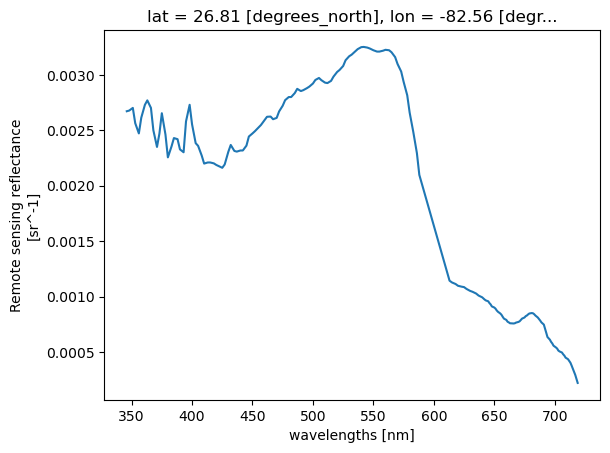

In [20]:
# See how fast this goes
%time

# Quick look at the water Reflectance 
pt = ds["Rrs"].sel(lat=lat, lon=lon, method="nearest")
pt.plot.line(x="wavelength")


## What if we have multiple points?

Let's just set up a simple loop to extact multiple points from a single image. 

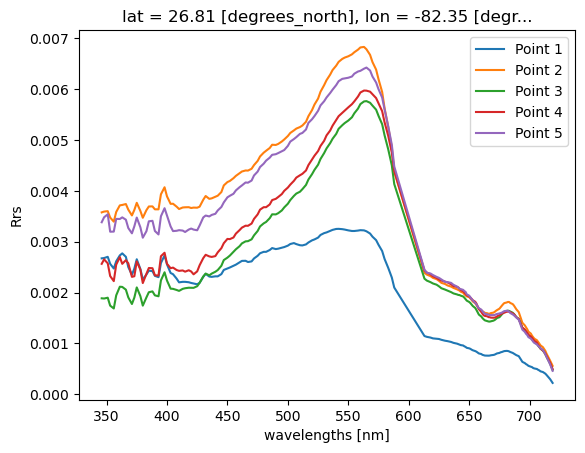

In [21]:
# Example list of points
points = [(26.79666, -82.578), (26.28597, -82.34245), (27.01283, -82.46982), (26.91813, -82.41211), (26.82491, -82.3501)]

for i, (lat, lon) in enumerate(points, start=1):
    pt = ds["Rrs"].sel(lat=lat, lon=lon, method="nearest")
    pt.plot.line(x="wavelength", label=f"Point {i}")   
plt.ylabel("Rrs")
plt.legend()
plt.show()

## Real example with lots of points

Realistically, you will be dealing with more than one in situ data point on more than one day. When we start to work across multiple time stamps, we increase the potential of running into memory issues. Let's illustrate this with a real world example using fish survey data in the Gulf of Mexico, and show some strategies for dealing with satellite matchups over time. 

## Get survey points

We are going to extract PACE satellite data at individual point locations, sampling single pixels across multiple time steps and spatial domains. As mentioned at the start of this tutorial, we got our paws on some ship-based NOAA Fisheries survey data from SEAMAP (2024–present). We’re going to extract PACE remote-sensing reflectance (Rrs) at each survey station, allowing us to sample satellite data at discrete point locations.

To keep things straightforward, we’ll start by importing a clean .csv file containing latitude, longitude, sampling date, as well as several in situ variables collected on the surveys, including temperature, salinity, oxygen, chlorophyll (fluorometry), turbidity, Secchi depth, and more. In addition, we want some form of fisheries data, so we also extracted the variable 'TOT_LIVE', which represents the combined wet weight (kg) of all fish, crustaceans, and other organisms caught. Is this the most meaningful fisheries metric available? Probably not, but it works well for illustrating the workflow, which is our main focus here. The SEAMAP dataset has plenty more to explore including species abundances and size information. 

If you’d like to try this out with your own data, any .csv containing columns labeled 'Latitude', 'Longitude', and 'Loc_date' (formatted as MM/DD/YYYY) should work seamlessly with the code below.


In [7]:
import pandas as pd
# Load ship data
url = (
    "https://raw.githubusercontent.com/"
    "fish-pace/2025-tutorials/main/"
    "Supporting_files/SEAMAP_summary_2024_present.csv"
)
track_df = pd.read_csv(url)
print(track_df.columns.tolist())
track_df

['STATIONID', 'CRUISEID', 'Loc_date', 'DECSLAT', 'DECELAT', 'DECSLON', 'DECELON', 'Latitude', 'Longitude', 'DEPTH_SSTA', 'WIND_SPD', 'WIND_DIR', 'MIN_FISH', 'TOT_LIVE', 'FIN_CATCH', 'CRUS_CATCH', 'OTHR_CATCH', 'CLD_COVER', 'SECCHI_DSK', 'WECOLOR', 'DEPTH_EMID', 'DEPTH_EMAX', 'DEPTH_EWTR', 'TEMPSURF', 'TEMPMID', 'TEMPMAX', 'SALSURF', 'SALMID', 'SALMAX', 'CHLORSURF', 'CHLORMID', 'CHLORMAX', 'OXYSURF', 'OXYMID', 'OXYMAX', 'TURBSURF', 'TURBMID', 'TURBMAX']


,STATIONID,CRUISEID,Loc_date,DECSLAT,DECELAT,DECSLON,DECELON,Latitude,Longitude,DEPTH_SSTA,...,SALMAX,CHLORSURF,CHLORMID,CHLORMAX,OXYSURF,OXYMID,OXYMAX,TURBSURF,TURBMID,TURBMAX
0,235611,1139,6/13/2024,27.378,27.389,-82.725,-82.750,27.3835,-82.7375,11.0,...,35.72,NaN,NaN,NaN,5.5,5.6,5.5,NaN,NaN,NaN
1,235612,1139,6/14/2024,27.115,27.123,-82.725,-82.700,27.1190,-82.7125,20.1,...,36.31,NaN,NaN,NaN,5.7,5.8,5.7,NaN,NaN,NaN
2,235613,1139,6/14/2024,26.931,26.956,-82.819,-82.815,26.9435,-82.8170,28.9,...,36.46,NaN,NaN,NaN,5.9,5.9,5.9,NaN,NaN,NaN
3,235614,1139,6/14/2024,26.700,26.675,-82.806,-82.807,26.6875,-82.8065,30.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,235615,1139,6/14/2024,26.678,26.657,-82.637,-82.654,26.6675,-82.6455,25.2,...,36.48,NaN,NaN,NaN,5.8,5.8,5.7,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590,236323,1150,6/14/2024,28.669,28.653,-91.198,-91.176,28.6610,-91.1870,10.2,...,36.18,5.547,4.828,7.123,5.8,6.0,4.3,78.5948,86.1352,29.5028
591,236324,1150,6/14/2024,28.897,28.901,-90.681,-90.653,28.8990,-90.6670,56.0,...,32.09,18.683,15.016,12.228,8.8,6.9,0.9,24.7280,63.2462,62.5680
592,236325,1150,6/14/2024,28.882,28.872,-90.535,-90.509,28.8770,-90.5220,91.0,...,35.81,12.675,8.132,9.457,7.8,3.8,0.2,43.5251,83.6422,65.8241
593,236326,1150,6/11/2024,28.513,28.494,-90.154,-90.136,28.5035,-90.1450,31.0,...,36.50,3.277,2.247,7.253,6.5,6.9,4.2,79.9584,86.4101,9.1834


In [8]:
track_df['TOT_LIVE']

0      173.1
1      142.0
2       44.6
3       56.5
4      193.7
       ...  
590     32.3
591      0.7
592      0.2
593      NaN
594      NaN
Name: TOT_LIVE, Length: 595, dtype: float64

The first order of business is to load the .csv file and identify all unique sampling dates. This is important because we’ll be retrieving data from NASA Earthdata, and it’s far more efficient to request each date only once rather than repeatedly downloading the same files.

In [9]:
# Load the dates and find all unique instances
track_df["Loc_date"] = pd.to_datetime(track_df["Loc_date"])
unique_dates = track_df["Loc_date"].sort_values().unique()
print(f"Number of unique dates to extract: {len(unique_dates)}")


Number of unique dates to extract: 61


## Map it out

Let's take a look at where all these stations are, and "slice" our data down to the bounds of the Gulf, so we're not taking up so much memory by loading in the entire planet (L3 data). For now, we're just loading in the single time point that we defined at the beginning of the tutorial, just to get a lay of the land.

/srv/conda/envs/notebook/lib/python3.12/site-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


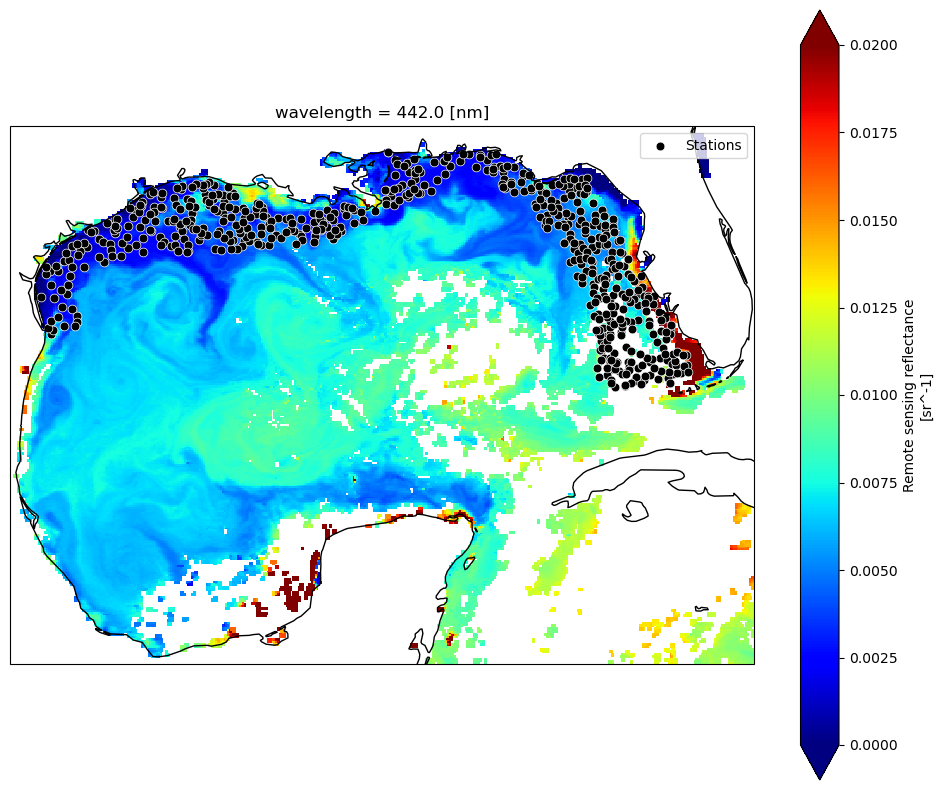

In [10]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Gulf bounds: (lat_max, lat_min, lon_min, lon_max)
ds_gulf = ds.sel(lat=slice(31, 18), lon=slice(-98, -80))
Rrs_443 = ds_gulf["Rrs"].sel(wavelength=443.0, method="nearest")

fig, ax = plt.subplots(figsize=(12, 10), subplot_kw={"projection": ccrs.PlateCarree()})
Rrs_443.plot(ax=ax, cmap="jet", add_colorbar=True, vmin=0, vmax=0.02)
ax.coastlines(resolution="50m")
ax.scatter(track_df["Longitude"], track_df["Latitude"], s=40, c="black", edgecolor="white", linewidth=0.5, label="Stations")
ax.legend(loc="upper right")
plt.show()


## DAY or 8D?

You have a bit of an existential decision to make here. At what temporal resolution will you extract your data? It will depend on your application, on your project goals, and the characteristics of your data. Trying to characterize general fish habitat preferences for highly migratory species? You can probably grab the closest 8-day average and make the assumption that most mesoscale features they interact with are coherent at weekly time scales. Looking at plankton tow information or counting fish species that are heavily reliant on tidal cycles? That data is likely a little more tied to the day it was collected, and you would want to look at daily values. The tradoff is that cloud cover is going to significantly chop down your data, and the weekly averages will help you get a lot more data back for model development. As an example, if ran the code below using 8-day versus 1-day composites, you would go from 532 valid matchups to 184 matchups, respectively. If your scientific question can tolerate loosening of the spatial/temporal time constraints, you may opt to use the longer composites - just be aware of your assumptions.

We're not tracking tuna across the Pacific here, this is trawl data along shelf environments in a highly dynamic system. In this case, I might opt to keep those temporal constraints a little tighter, assuming that the location of e.g., river pulses or other submesoscale physical mixing processes are changing drastically from day to day.

## Getting multiple matchups

For every unique date found in the .csv, we're going to query NASA for that corresponding daily Level 3 file. Then, for that file, we're going to loop through all the points within that day and find the nearest lat/lon pixel and get the reflectance spectrum. We're going to collect this info in a 'dictionary' and then append the data to our .csv in one swoop at the end. 

We will use an approach that allows us to release memory after loading each dataset. This avoids stacking up memory and crashing your kernel. For one, we're streaming via `earthaccess.open()`, which returns EarthAccessFile objects that stream the data on-demand. Only the chunks of data you actually access with xarray (`ds["Rrs"].isel(...)`) are read into memory. Secondly, using `with` statements ensures that datasets are closed immediately after processing. Once the block ends, memory used by `ds` is released, and we avoid keeping multiple files open at the same time. 

Still, if we want to keep memory down (and prevent our kernel from crashing), we're going to query satellite files one (unique) day at a time. This is the largest bottleneck. If you have the memory, it would likely be quicker to download the files all at once and then extract the data in one swoop. We prefer keeping in cloud space here. It doesn't take but 2-4 minutes for this example, but now is a good time for a beverage/bio break. For the sake of this tutorial, feel free to skip this section, since we provide the output for the next section.

In [ ]:
import earthaccess
import xarray as xr
import pandas as pd
import numpy as np
from tqdm import tqdm
import re

# Login
auth = earthaccess.login()
short_name = "PACE_OCI_L3M_RRS"
granule_name = "*.DAY.*.4km.*"
# Want 8D composites instead?
#granule_name = "*.8D.*.4km.*"
results_list = []

# Loop through unique dates
for date in tqdm(unique_dates, desc="Processing unique dates"):
    start = end = date.strftime("%Y-%m-%d")
    # Search & open files for exact date
    results = earthaccess.search_data(short_name=short_name, temporal=(start, end), granule_name=granule_name)
    fileset = earthaccess.open(results)

    for ea_file in fileset:  # iterate EarthAccessFile objects
        with xr.open_dataset(ea_file, engine="h5netcdf") as ds:
            points_today = track_df[track_df["Loc_date"] == date]
            
            for idx, row in tqdm(points_today.iterrows(), total=len(points_today), desc="Points in granule", leave=False):
                lat_center, lon_center = row["Latitude"], row["Longitude"]
                rrs = ds["Rrs"].sel(lat=lat_center, lon=lon_center, method="nearest")
                result_row = {'Original_Index': idx, **row.to_dict()}
                result_row.update({f"Rrs_{int(wl)}": val for wl, val in rrs.to_series().items()})
                results_list.append(result_row)

# Combine results & save
if results_list:
    final_df = pd.DataFrame(results_list).set_index("Original_Index").sort_index()
    output_file = "SEAMAP_summary_2024_present_PACE_RRS_1D_centerpixel.csv"
    final_df.to_csv(output_file)
    print(f"CSV saved: {output_file}")
else:
    print("No data extracted. Check date ranges and data availability.")

## 3x3 averages instead of one pixels

In many L2 workflows, it is standard practice to extract a 3×3 or 5×5 pixel window rather than a single center pixel. This provides a mean and standard deviation that help characterize small-scale spatial heterogeneity, increase the likelihood of retrieving valid data, and reduce sensitivity to clouds or isolated bad pixels. Although L3 products have already been spatially binned (here to 4-km resolution), the same conceptual motivation can still apply. Depending on the science question, you may be less interested in the exact value at a single grid cell and more interested in the broader environmental context of the surrounding waters. For habitat-oriented fisheries applications, averaging over a small neighborhood can better represent the conditions a mobile organism may be experiencing, rather than assuming it responds to a single pixel value. Below, we show how the previous center-pixel extraction can be modified to compute a simple 3×3 pixel mean around each location.

In [ ]:
import earthaccess
import xarray as xr
import pandas as pd
import numpy as np
from tqdm import tqdm
import re

# Login
auth = earthaccess.login()
# Provide product parameters
short_name = "PACE_OCI_L3M_RRS"
granule_name = "*.DAY.*.4km.*"

results_list = []

# Loop through unique dates
for date in tqdm(unique_dates, desc="Processing unique dates"):

    start = end = date.strftime("%Y-%m-%d")

    # Search & open files for exact date
    results = earthaccess.search_data(short_name=short_name, temporal=(start, end), granule_name=granule_name)
    fileset = earthaccess.open(results)

    for ea_file in fileset:  # iterate EarthAccessFile objects
        with xr.open_dataset(ea_file, engine="h5netcdf") as ds:
            points_today = track_df[track_df["Loc_date"] == date]
            lat_vals = ds.lat.values
            lon_vals = ds.lon.values
            
            for idx, row in tqdm(points_today.iterrows(), total=len(points_today), desc="Points in granule", leave=False):
                lat_center, lon_center = row["Latitude"], row["Longitude"]
                lat_idx = np.abs(lat_vals - lat_center).argmin()
                lon_idx = np.abs(lon_vals - lon_center).argmin()
                lat_slice = slice(max(lat_idx-1,0), min(lat_idx+2,len(lat_vals)))
                lon_slice = slice(max(lon_idx-1,0), min(lon_idx+2,len(lon_vals)))
    
                rrs_box = ds["Rrs"].isel(lat=lat_slice, lon=lon_slice)
                rrs_mean = rrs_box.mean(dim=["lat","lon"], skipna=True)

                # Prepare row dict
                result_row = {'Original_Index': idx, **row.to_dict()}
                result_row.update({f"Rrs_{int(wl)}": val for wl, val in rrs_mean.to_series().items()})
                results_list.append(result_row)

# Combine results & save
if results_list:
    final_df = pd.DataFrame(results_list).set_index("Original_Index").sort_index()
    output_file = "SEAMAP_summary_2024_present_PACE_RRS_1D_3x3mean.csv"
    final_df.to_csv(output_file)
    print(f"CSV saved: {output_file}")
else:
    print("No data extracted. Check date ranges and data availability.")

## Okay, one more iteration (2D products)

Fine, we'll come down off of our Remote Sensing Reflectance box and show you how to extract single variables instead. Rrs is a 3D variable, while most other products are 2D variables (e.g., chlor_a, avw, poc, etc.). Same basic code, but we "flatten" the values before adding to the dictionary. Just modify the PRODUCT inputs to match your product of interest. 

In [ ]:
import earthaccess
import xarray as xr
import pandas as pd
import numpy as np
from tqdm import tqdm
import re

PRODUCT = {
    "short_name": "PACE_OCI_L3M_AVW",
    "var": "avw",          # variable name inside the dataset
    "label": "AVW",        # used in column names & output file
    "granule": "*.DAY.*.4km.*"
}

# Login
auth = earthaccess.login()
short_name = PRODUCT["short_name"]
granule_name = PRODUCT["granule"]
results_list = []

# Loop through unique dates
for date in tqdm(unique_dates, desc="Processing unique dates"):
    start = end = date.strftime("%Y-%m-%d")
    # Search & open files for exact date
    results = earthaccess.search_data(short_name=short_name, temporal=(start, end), granule_name=granule_name)
    fileset = earthaccess.open(results)

    for ea_file in fileset:  # iterate EarthAccessFile objects
        with xr.open_dataset(ea_file, engine="h5netcdf") as ds:
            points_today = track_df[track_df["Loc_date"] == date]
            
            for idx, row in tqdm(points_today.iterrows(), total=len(points_today), desc="Points in granule", leave=False):
                lat_center, lon_center = row["Latitude"], row["Longitude"]
                da = ds[PRODUCT["var"]].sel(lat=lat_center, lon=lon_center, method="nearest")
                result_row = {'Original_Index': idx, **row.to_dict()}
                values = np.atleast_1d(da.values).flatten()
                result_row.update({f"{PRODUCT['label']}_{i}": val for i, val in enumerate(values)})
                results_list.append(result_row)

# Combine results & save
if results_list:
    final_df = pd.DataFrame(results_list).set_index("Original_Index").sort_index()
    output_file = f"SEAMAP_summary_2024_present_PACE_{PRODUCT['label']}_centerpixel.csv"
    final_df.to_csv(output_file)
    print(f"CSV saved: {output_file}")
else:
    print("No data extracted. Check date ranges and data availability.")

## Let's explore a bit

For every data point that we read in which had a lat/lon/date, we now have a corresponding Rrs spectrum (or whatever PACE products you chose to pull). For something as complex and nuanced as habitat modeling, we're not likely to see a tight correlation between Rrs and total fish catch ("TOT_LIVE"), but it's a good exercise to explore the relative significance of including PACE data. Before we do anything with this data, let's just see what the average shape of Rrs looks like at various fish biomass levels. First, let's open up that spreadsheet we just created:

In [ ]:
import numpy as np
import pandas as pd
url = (
    "https://raw.githubusercontent.com/"
    "fish-pace/2025-tutorials/main/"
    "Supporting_files/SEAMAP_summary_2024_present_PACE_RRS_1D_3x3mean.csv"
)
df2 = pd.read_csv(url)

tot_live = df2["TOT_LIVE"].replace(0, np.nan)  # avoid log(0)
rrs_cols = [c for c in df2.columns if c.startswith("Rrs_")]
wavelengths = np.array([int(c.split("_")[1]) for c in rrs_cols])

print(f"Min value in TOT_LIVE: {np.min(tot_live)}")
print(f"Max value in TOT_LIVE: {np.max(tot_live)}")

Since we're dealing with living things, and the biomass data extends across 3 orders of magnitude, let's go ahead and log-transform the biomass data so that it normalizes the distribution a bit. Below, what this allows us to do is define a custom number of equally spaced bins (in log10 space), in which we can take the mean of all Rrs spectra within each bin, and plot it out. This is qualitative exploration at this point, but it feeds into our devious plot to demystify spectral reflectance data and get a general sense of patterns.


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Define log-space bins
safe_tot = tot_live.clip(lower=1e-6) #this avoids issues with zeros
num_bins = 10
bins_log = np.logspace(np.log10(safe_tot.min()), np.log10(safe_tot.max()), num_bins + 1)
df2["bin_log"] = pd.cut(safe_tot, bins_log, include_lowest=True)

# Compute mean spectra per bin
mean_spectra = df2.groupby("bin_log", observed=True)[rrs_cols].mean().dropna(how="all")

# Plot
cmap = plt.colormaps.get_cmap("viridis")
colors = cmap(np.linspace(0, 1, len(mean_spectra)))
plt.figure(figsize=(10,6))

for (bin_interval, row), color in zip(mean_spectra.iterrows(), colors):
    label = f"{bin_interval.left:.2f}-{bin_interval.right:.2f}"
    plt.plot(wavelengths, row.values, color=color, linewidth=2, label=label)

plt.xlabel("Wavelength (nm)")
plt.xlim(400, 715)
plt.ylabel("Mean Rrs (1/sr)")
plt.title("Mean Rrs Spectra Across log(TOT_LIVE) Bins")
plt.legend(title="TOT_LIVE bins (kg of catch)", bbox_to_anchor=(1.05,1), loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()

## Yay! More squiggly lines!

Generally speaking, catch biomass increases in greener, phytoplankton-dominated waters and decreases in bluer waters (no big surprise). Interestingly, we find an exception to this trend in the lowest biomass bin (0.43 - 0.94 kg) - this contains average green-shifted reflectance spectra, but the magnitude of total reflectance is significantly lower than the others. What's the deal? As we discussed in the Rrs tutorial, the low magnitude likely suggests the presence of highly absorbing materials... CDOM plume perhaps? High CDOM levels tends to be a result of allochthonous inputs, i.e., river runoff. If this is the case, we're likely to see lower salinity in these waters as well. That still doesn't explain the low biomass though. Just for funzies, let's take a look at some of those other environmental parameters collected using the same biomass bin parameters. We'll pull surface temperature, surface salinity, bottom salinity, and bottom oxygen. 

In [ ]:
# Compute mean salinity + oxygen per bin
mean_vals = df2.groupby("bin_log", observed=True)[["TEMPSURF", "SALSURF", "SALMAX", "OXYMAX"]].mean()

# Print each bin with both means
for bin_interval, row in mean_vals.iterrows():
    print(
        f"bin interval: {bin_interval.left:.2e} - {bin_interval.right:.2e} --->    "
        f"mean TEMPSURF = {row['TEMPSURF']:.2f},    "
        f"mean SALSURF = {row['SALSURF']:.2f},    "
        f"mean SALBTM = {row['SALMAX']:.2f},    "
        f"mean OXYBTM = {row['OXYMAX']:.2f}"
    )


## Holy Hypoxia!

Yessiree Bob. $\Delta$Salinity between surface and bottom implies a freshwater lense has stratified the water column. With (presumably) high nutrients, low benthic light (no photosynthesis), and trapped bottom waters, we see the system has become hypoxic/borderline anoxic (low to no oxygen) owing to the cumulative effect of microbial respiration in waters that are not being ventilated to the surface. Classic "Dead Zone". No wonder there are no fishies there! Anyhow, we're getting away from our main point, but just by looking at the reflectance data patterns, we were able to initially flag that environmental parameters are a bit different here. Now back to our programming. 

## Oooooh, let's make a correlation matrix!!

What? It's exciting. We have a lot of spectral data, what else can we tease out here? Again, we're not expecting any sort of robust relationship here, but let's keep using TOT_LIVE, and see if there are additional inferences that emerge between hyperspectral PACE reflectances and fish catch. First, let's pull out all that new data we got running the matchup script.

In [ ]:
# Extract Rrs bands + wavelengths between 400–700 nm 
rrs_cols = [c for c in df2.columns if c.startswith("Rrs_") and 400 <= float(c.split("_")[1]) <= 700]
rrs_cols = sorted(rrs_cols, key=lambda c: float(c.split("_")[1]))
wavelengths = np.array([float(c.split("_")[1]) for c in rrs_cols])

# Clipping outliers and zeros to avoid division errors
rrs = df2[rrs_cols].clip(lower=0.000001, upper=0.5)
rrs.columns = wavelengths  # ensure numeric labels

After taking a look at the mean hyperspectral Rrs across the different biomass catch bins, we want to dig a little deeper and be more quantitative. To do that, we’re going to play with a simple two-band algorithm approach, where we combine pairs of spectral bands using basic math. Focusing on two bands allows us to make a really useful plot that showcases the utility of hyperspectral data: a pairwise correlation matrix. This provides basic information on narrowband features that may be related to our given parameter of interest. We're not ignoring the hyperspetral data, we're actually leveraging it to optimize the best answer.

For this round, we’ll use a normalized difference index (NDI), mostly because it’s simple and kind of fun:

$NDI = ({\lambda}_{1} - {\lambda}_{2}) / ({\lambda}_{1} + {\lambda}_{2})$

There’s no particular scientific reason we have to use NDI here. For a pairwise correlation matrix, you could just as easily use any two-band mathematical combination, e.g. ratios, subtractions, exponents, etc. NDI is just a convenient, well-behaved choice to start with.

Using the hyperspectral bands we have, we’ll compute every possible two-band NDI combination. Then, for each band pair, we’ll look at how well that NDI correlates with our parameter of interest (in this case, TOT_LIVE). Plotting those correlation coefficients as a heatmap gives us a quick way to see which band combinations look most promising.

With over 100 bands at our disposal, the hyperspectral capability of PACE really opens things up, letting us test band combinations that simply haven’t been explored before. Fair warning: running all those combinations might take a minute.

In [ ]:
import seaborn as sns

# Identify target variable
param = "TOT_LIVE"
target = np.log10(df2[param].clip(lower=1e-4))

# Set up NDI correlation matrix
ndi_corr = pd.DataFrame(index=wavelengths, columns=wavelengths, dtype=float)

# Loop NDI calculation + correlation with target
for wl1 in wavelengths:
    for wl2 in wavelengths:
        if wl1 == wl2:
            continue
        ndi = (rrs[wl1] - rrs[wl2]) / (rrs[wl1] + rrs[wl2])
        ndi_corr.at[wl1, wl2] = ndi.corr(target)

# Plot
mask = np.triu(np.ones_like(ndi_corr, dtype=bool))
cmax = max(0.1, np.nanmax(np.abs(ndi_corr.values)))

plt.figure(figsize=(10, 8))
sns.heatmap(
    ndi_corr, cmap="coolwarm", center=0,
    mask=mask | ndi_corr.isna().values,
    vmin=-cmax, vmax=cmax,
    xticklabels=50, yticklabels=50,
    cbar_kws={"label": f"Correlation with {param}"}
)
plt.title(f"Band Ratio Correlation with {param}", fontsize=16)
plt.xlabel("λ₂ (nm)")
plt.ylabel("λ₁ (nm)")
plt.tight_layout()
plt.show()

Cool, cool. We're kind of eye-balling it at this point, so let's sort out what the 5 best combos were. It is likely that the first 5 combinations will be very close to one another due to cross-correlation of the nearby color bands, so you are welcome to put out a hundred values if you'd like (it'll just be a ltitle messy).

In [ ]:
# How many correlations do you want to see?
order_index = 5

# Flatten the correlation matrix and drop NaNs
ndi_flat = ndi_corr.stack().dropna()

# Sort by absolute correlation
top_5_ndi = ndi_flat.reindex(ndi_flat.abs().sort_values(ascending=False).index).head(order_index)

# Print the results
print(f"\nTop 5 NDI combinations by absolute correlation with {param}:")
for (wl1, wl2), corr in top_5_ndi.items():
    print(f"λ₁ = {int(wl1)} nm, λ₂ = {int(wl2)} nm --> r = {corr:.4f}")

## Will PACE actually improve a rudimentary fish abundance model?

As we’ve iterated a few times through this tutorial, we’re not expecting PACE alone to be a silver bullet for predicting fish abundance. That said, the top correlations aren’t abhorrent, so let’s see what happens when we take our top contender and combine it with in situ environmental variables collected on the ship (temperature, salinity, oxygen, chlorophyll, and turbidity).

To do this, we’ll use a boosted regression tree (BRT). A BRT is an ensemble method that builds lots of small decision trees and then combines them, with each new tree focusing on correcting the errors of the previous ones. This makes it good at capturing nonlinear relationships and interactions between predictors without needing to specify them upfront.

We’ll also use a train/test split (bootstrapping) so the model is fit on one subset of the data and evaluated on another, which helps reduce overfitting and gives us a better sense of how well the model might perform on unseen data. Let's get things set up.


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error

# Column names of the Rrs bands to combine
wavelength1 = "Rrs_400"
wavelength2 = "Rrs_647"

# Simple environmental predictors
ENV_VARS = ["TEMPSURF", "SALSURF", "OXYSURF", "TURBSURF", "CHLORSURF"]

df3 = df2[df2["TOT_LIVE"].notna()].copy()

# Create a new column in df for the ratio
Rrs_ratio = f"ndi_{wavelength1}_{wavelength2}"
df3[Rrs_ratio] = (df3[wavelength1] - df3[wavelength2]) / (df3[wavelength1] + df3[wavelength2])

predictors = [Rrs_ratio] + ENV_VARS
# To see what the model would look like without PACE, use:
#predictors = ENV_VARS
X = df3[predictors]
y = np.log10(df3["TOT_LIVE"])

# Get rid of NaNs, BRT gets mad otherwise
mask = X.notna().all(axis=1)
X = X[mask]
y = y[mask]

print(f"Predictors used: {predictors}")
print(f"Number of samples: {len(y)}")

You'll notice that we only have 97 total samples that got a PACE return + had all the environmental parameters simultaneously collected. This is a bit of a spotty dataset, so take the results here with a grain of salt. 

## Boosted Regression Tree setup

First, we'll split the dataset into training and testing subsets using *train_test_split*. Here, *test_size=0.2* means that 20% of the data are held out for testing, while the remaining 80% are used to train the model. The *random_state=42* just fixes the random seed so the split is reproducible; using 42 is arbitrary (the answer to the universe and everything), but it ensures we get the same results every time we run the code. Remove random_state if you want the results to change with every run.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Next, we'll set up a boosted regression tree using *GradientBoostingRegressor*. This model builds an ensemble of many shallow decision trees (n_estimators=800, max_depth=3), added sequentially so that each new tree focuses on correcting errors made by the previous ones. The small learning_rate=0.01 slows the learning process to improve generalization, while subsample=0.8 introduces randomness by training each tree on 80% of the data, which helps reduce overfitting. We again set random_state=42 to keep the model behavior reproducible.


In [ ]:
brt = GradientBoostingRegressor(n_estimators=800, learning_rate=0.01, max_depth=3, subsample=0.8, random_state=42)
#brt = GradientBoostingRegressor(n_estimators=800, learning_rate=0.01, max_depth=3, subsample=0.8)
brt.fit(X_train, y_train)

After fitting the model to the training data, we use it to predict the held-out test data. Model performance is then evaluated using Pearson’s correlation coefficient (r), the coefficient of determination (R²), the root mean squared error (RMSE), and the median absolute percent error (MdAPE) giving us a quick sense of how well the model captures both the strength of the relationship and the overall prediction error.

In [ ]:
y_pred = brt.predict(X_test)

r = np.corrcoef(y_test, y_pred)[0, 1]
r2 = r2_score(y_test, y_pred)

# For error metrics, let's get back in linear space so we can interpret
y_test_lin = 10 ** y_test
y_pred_lin = 10 ** y_pred
rmse_lin = np.sqrt(mean_squared_error(y_test_lin, y_pred_lin))
mdape = np.median(np.abs((y_pred_lin - y_test_lin) / y_test_lin)) * 100

print(f"BRT Pearson r : {r:.3f}")
print(f"BRT R²        : {r2:.3f}")
print(f"BRT RMSE (linear space)   : {rmse_lin:.3f} kg")
print(f"BRT MdAPE (linear space)   : {mdape:.1f}%")

# How'd we do?

Finally, let’s visualize how well the model is doing and see which predictors the BRT relied on most. We’ll make a scatter plot of observed vs. predicted values as well as a STAR plot of "feature" importance.

In [ ]:
# Prepare data for STAR plot
importances = brt.feature_importances_
importances = importances / importances.sum()
labels = predictors
angles = np.linspace(0, 2 * np.pi, len(importances), endpoint=False)

# Close the loop for polar plot
angles = np.concatenate([angles, angles[:1]])
importances_plot = np.concatenate([importances, importances[:1]])

# Create side-by-side figure
fig = plt.figure(figsize=(12, 6))

# Scatter plot (left)
ax1 = fig.add_subplot(1, 2, 1)
ax1.scatter(y_test_lin, y_pred_lin, alpha=0.6, edgecolor="k")
ax1.plot([y_test_lin.min(), y_test_lin.max()], [y_test_lin.min(), y_test_lin.max()], "r--")
ax1.set_xlabel("Observed TOT_LIVE")
ax1.set_ylabel("Predicted TOT_LIVE")
ax1.set_title("BRT: Observed vs Predicted")
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.grid(True)

# Polar plot (right)
ax2 = fig.add_subplot(1, 2, 2, polar=True)
ax2.plot(angles, importances_plot, linewidth=2)
ax2.fill(angles, importances_plot, alpha=0.3)
ax2.set_theta_direction(-1)
ax2.set_theta_offset(np.pi / 2)
ax2.set_xticks(angles[:-1])
ax2.set_xticklabels(labels)
#ax2.set_title("BRT Feature Importance", pad=25)

plt.tight_layout()
plt.show()



On the left, we have a scatter plot comparing the BRT’s predicted values to the observed values of our target. On the right, the STAR (polar) plot shows the relative importance of each predictor. In a BRT, a variable’s importance reflects how much it contributed to reducing prediction error across all the trees. Higher values mean the model “relied on” that variable more. These values are normalized to sum to 1, so you can see at a glance which predictors had the biggest influence on the model, even when interactions and nonlinear effects are present.

Turns out the PACE NDI was the second most influential factor in the model, behind surface temperature. I wouldn't hang your hat on predicting fish catch with this model, but we did seem to at least capture a directional trend, with a modest, but respectible statistical correlation. Again, keep in mind, we only had 97 points, so our test dataset only consists of 20 points. If you try running the same model above without the presence of PACE data, you'll notice that the relationship is not as strong, but also that it picks up ~150 additional observations becuase it didn't have to filter by co-occuring satellite data (lot's of which was missing due to cloud cover).

## Now the science begins!

Overall, this tutorial illustrates a workflow that’s very common in satellite data work: matching spatially and temporally explicit observations to environmental data, exploring relationships, and trying out simple predictive models. The bigger takeaway isn’t the specific numbers or predictions, but rather the approach. We learned how to handle satellite matchups, extract relevant data, and start exploring how environmental and spectral variables relate to biological patterns. With more data and further tuning, these workflows could be extended to better understand habitat use, fishing hotspots, or other ecological questions. In short, we hope that the tools and concepts you practiced here provide a solid foundation for integrating remote sensing and fisheries science in your own work.